In [1]:
import tensorflow as tf
from tensorflow.keras import layers

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import time

from IPython import display
import PIL

In [2]:
# loading my dataset here

# mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# remove a folder
# !rm -rf dataset
# unzip dataset folder
!unzip '/content/gdrive/MyDrive/AI-Assets/GAN/dataset.zip' > /dev/null

In [4]:
# Global Variables
AUTOTUNE = tf.data.experimental.AUTOTUNE
# BUFFER_SIZE = 60000
BATCH_SIZE = 32
IMAGE_SIZE = 256
IMAGE_CHANNELS = 3

assert IMAGE_SIZE % 4 == 0

In [5]:
# Get All The Files
filenames = tf.io.gfile.glob('/content/dataset/Sloth/*')
filenames.extend(tf.io.gfile.glob('/content/dataset/Vu/*'))
# print(filenames)

IMG_CNT = len(filenames)
print(f"Total Number of Vu and Sloth Images for Training: {IMG_CNT}")

Total Number of Vu and Sloth Images for Training: 334


In [6]:
# Batch and shuffle the data
train_ds = tf.data.Dataset.from_tensor_slices(filenames)

In [7]:
# # Load and Prepare the MNIST dataset
# (train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

for f in train_ds.take(5):
  print(f.numpy())

b'/content/dataset/Sloth/111.png'
b'/content/dataset/Sloth/122.png'
b'/content/dataset/Sloth/9.png'
b'/content/dataset/Sloth/118.png'
b'/content/dataset/Sloth/44.png'


In [8]:
# train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

# Normalise images to [-1, 1]
def Normalise(image):
  image = (image - 127.5) / 127.5
  return image

In [9]:
# Decode images
def DecodeImg(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.cond(
          tf.image.is_jpeg(img),
          lambda: tf.image.decode_jpeg(img, IMAGE_CHANNELS),
          lambda: tf.image.decode_png(img, IMAGE_CHANNELS))
  # img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  img = tf.image.resize(img, [IMAGE_SIZE, IMAGE_SIZE])
  # Use `convert_image_dtype` to convert to floats in the [-1,1] range.
  img = Normalise(img)
  return img

In [10]:
def ProcessPath(file_path):
  image = tf.io.read_file(file_path)
  image = DecodeImg(image)
  return image

In [11]:
# train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_ds = train_ds.map(ProcessPath, num_parallel_calls=AUTOTUNE).shuffle(IMG_CNT).cache().batch(BATCH_SIZE)

In [12]:
image_batch = next(iter(train_ds))
image_batch.shape

TensorShape([32, 256, 256, 3])

In [13]:
# Show batch of images
def show_batch(image_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

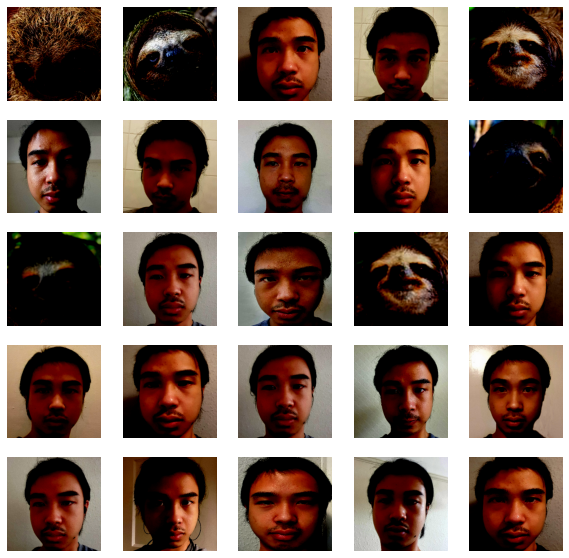

In [14]:
show_batch(image_batch)

In [15]:
EPOCHS = 25000
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [16]:
def make_generator_model():
    model = tf.keras.Sequential()
    # model.add(layers.Dense(7*7*1024, use_bias=False, input_shape=(100,)))
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    # model.add(layers.Reshape((7, 7, 1024)))
    # assert model.output_shape == (None, 7, 7, 1024)  # Note: None is the batch size

    # model.add(layers.Conv2DTranspose(512, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # assert model.output_shape == (None, 7, 7, 512)
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    # model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 14, 14, 256)
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    # model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 28, 28, 128)
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    # model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 56, 56, 64)
    # model.add(layers.BatchNormalization())
    # model.add(layers.LeakyReLU())

    # model.add(layers.Conv2DTranspose(IMG_CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # assert model.output_shape == (None, 112, 112, IMG_CHANNELS)

    model = tf.keras.Sequential()

    n = IMAGE_SIZE // 4

    model.add(layers.Dense(n * n * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((n, n, 256)))
    # assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    # assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    # assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(IMAGE_CHANNELS, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    # assert model.output_shape == (None, 28, 28, 3)

    return model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


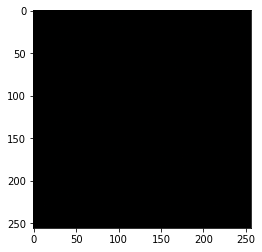

In [17]:
generator = make_generator_model()

noise = tf.random.normal([BATCH_SIZE, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0])
plt.show()

In [18]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[IMAGE_SIZE, IMAGE_SIZE, IMAGE_CHANNELS]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [19]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor(
[[-1.5524727e-04]
 [ 7.6171782e-06]
 [-3.5876430e-05]
 [-2.0060501e-04]
 [-5.8705496e-05]
 [-1.1717420e-04]
 [ 2.7583192e-05]
 [-9.6766365e-05]
 [-6.4885782e-05]
 [ 1.7258084e-05]
 [-7.5139513e-05]
 [-1.6719250e-05]
 [-8.9640453e-05]
 [ 4.9531383e-05]
 [-9.4408155e-05]
 [-4.4041673e-05]
 [-2.4441531e-04]
 [ 2.8844384e-05]
 [-2.3445545e-04]
 [ 2.9839030e-05]
 [ 2.6438955e-05]
 [-7.3108313e-05]
 [ 3.3904635e-06]
 [-3.6512814e-05]
 [-4.3213877e-05]
 [ 4.4829343e-05]
 [-1.3041405e-04]
 [-2.2030926e-04]
 [-7.5324693e-05]
 [-1.2372572e-04]
 [-1.4549939e-04]
 [-1.3492320e-04]], shape=(32, 1), dtype=float32)


In [20]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [21]:
# Calculate the discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [22]:
# Calculate the generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [24]:
# Save checkpoints in case a long running training task is interrupted
checkpoint_dir = '/content/gdrive/MyDrive/AI-Assets/GAN/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [25]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [26]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
step = 200

In [28]:
def train(dataset, epochs):
  start_of_training = time.time()
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 200 epochs
    if (epoch + 1) % step == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)
  print ('Time for the entire training to finish with a total number of {} epochs is {} sec'.format(epoch + 1, time.time()-start_of_training))

In [29]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      if predictions.shape[-1] == 3:
            plt.imshow(
                predictions[i] * 0.5 + .5)  # scale image to [0, 1] floats (or you could also scale to [0, 255] ints)
      else:
          plt.imshow(predictions[i, :, :, 0] * 0.5 + .5,
                      cmap='gray')  # scale image to [0, 1] floats (or you could also scale to [0, 255] ints)
      # plt.imshow(predictions[i, :, :, :] * 127.5 + 127.5)
      plt.axis('off')

  # Save the images every 200 epochs
  if (epoch) % step == 0: 
    plt.savefig('/content/gdrive/MyDrive/AI-Assets/GAN/image_at_each_200_epoch/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

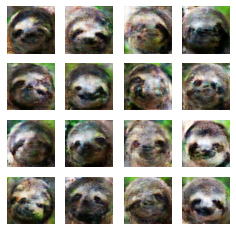

Time for epoch 1890 is 14.565997123718262 sec


In [ ]:
train(train_ds, EPOCHS)

In [ ]:
# Create a GIF
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('/content/gdrive/MyDrive/AI-Assets/GAN/image_at_each_200_epoch/image_at_epoch_{:04d}.png'.format(epoch_no))

In [ ]:
# Display the latest image (25,000 / 200 = 125)
display_image(EPOCHS / step)

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        image = imageio.imread(filename)
        writer.append_data(image)

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)